In [1]:
%load_ext autoreload
%autoreload 2

In [110]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use("bioAI.mplstyle")
import torch
import tqdm
import scipy

import sys
sys.path.append('../')
from methods import permutation_test, Hexagon
from models import JitterCI, JacobianCI
from plotting_functions import set_size, colorbar_axis, multiimshow
from utils import rotation_matrix, find_peaks

In [141]:
color_cycler = plt.rcParams['axes.prop_cycle'].by_key()['color']
savefigs = False
dpi=150

In [10]:
def train_model(model, dtype = torch.float32):
    # Train model
    nsamples_space = 2**8
    loss_history = []
    for _ in tqdm.trange(5000):
        rs = model.unit_cell.sample(nsamples_space)
        rs = torch.tensor(rs,dtype=dtype)
        loss = model.train_step(rs)
        loss_history.append(loss)
    loss_history = np.array(loss_history)
    return loss_history

In [93]:
# load trained model
dtype = torch.float32
# choose seed such that metagon is contained in zero-centered unit cell
model = JacobianCI(ncells=7,dtype=dtype,lr=1e-3, shift=0, p_magnitude=0, seed=3)
loss_history = train_model(model)

100%|██████████| 5000/5000 [00:06<00:00, 748.49it/s]


In [104]:
res = 32
radius = 7.169 # all_ratemaps[2]
rel_box_size = model.unit_cell.radius * res / radius

x = np.linspace(-rel_box_size/2,rel_box_size/2,res)
y = np.linspace(-rel_box_size/2,rel_box_size/2,res)
X,Y = np.meshgrid(x,y)
square_mesh = np.stack([X,Y],axis=-1)
square_mesh.shape

(32, 32, 2)

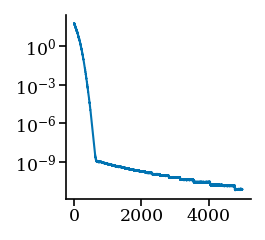

In [105]:
plt.semilogy(loss_history)

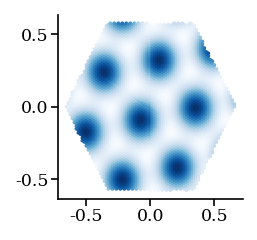

In [106]:
kde, mesh, kernel, expanded_phases = model.phase_kde(bw_method=0.1)
plt.scatter(*mesh.T, c=kde, s=0.5)

In [137]:
# calculate ratemaps with given resolution and find peaks in the sqaure mesh
ratemaps = model(torch.tensor(square_mesh.reshape(-1,2),dtype=dtype)).detach().numpy().reshape(res,res,-1)
center_peaks = np.array([find_peaks(ratemaps[:,:,i])[0] for i in range(ratemaps.shape[-1])])
# convert peaks to unit cell coordinates again
center_peaks = center_peaks / res * rel_box_size - rel_box_size/2

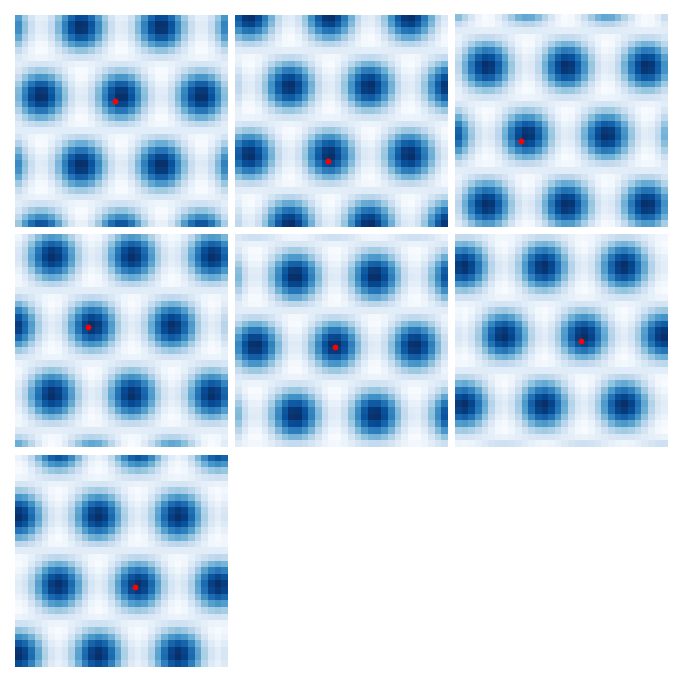

In [138]:
fig, axs = multiimshow(ratemaps.transpose(2,1,0), origin='lower', figsize=(5,5), normalize=False, 
                       extent=(-rel_box_size/2,rel_box_size/2,-rel_box_size/2,rel_box_size/2));
for i in range(len(center_peaks)):
    axs[i].scatter(*center_peaks[i], color='red', s=3)

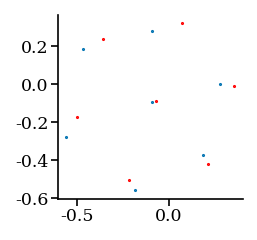

In [135]:
plt.scatter(*center_peaks.T)
plt.scatter(*model.phases.detach().numpy().T, color='red')

In [147]:
#model.set_phases(center_peaks)

In [148]:
import copy 

nperms = 40
#stds = np.linspace(0.02, 0.1, 3)
stds = [0.01, 0.05, 0.15]
ball_radii = np.linspace(0, model.unit_cell.radius, 21)[1:]
ripleys = np.zeros((nperms, len(stds), len(ball_radii)))
phases_multiple = 15
for i in tqdm.trange(nperms):
    for j in range(len(stds)):
        tmp_phases = model.phases.detach().numpy()[:,None] + np.random.normal(0, stds[j], size=(phases_multiple,2))[None]
        tmp_phases = tmp_phases.reshape(-1,2)
        tmp_phases = model.unit_cell.wrap(tmp_phases)
        tmp_model = copy.deepcopy(model)
        tmp_model.set_phases(tmp_phases)
        tmp_model.set_scale()
        for k in range(len(ball_radii)):
            ripley = tmp_model.ripleys(ball_radii[k])
            ripleys[i,j,k] = ripley
ripleys = np.array(ripleys)

100%|██████████| 40/40 [00:14<00:00,  2.84it/s]


In [149]:
ripleys_random_uniform = np.zeros((nperms, len(ball_radii)))
for i in tqdm.trange(nperms):
    tmp_phases = model.phases.detach().numpy()[:,None] + model.unit_cell.sample(15)[None]
    tmp_phases = tmp_phases.reshape(-1,2)
    tmp_phases = model.unit_cell.wrap(tmp_phases)
    tmp_model = copy.deepcopy(model)
    tmp_model.set_phases(tmp_phases)
    tmp_model.set_scale()
    for j in range(len(ball_radii)):
        tmp_ripley = tmp_model.ripleys(ball_radii[j])
        ripleys_random_uniform[i,j] = tmp_ripley
ripleys_random_uniform = np.array(ripleys_random_uniform)

100%|██████████| 40/40 [00:04<00:00,  8.91it/s]


In [150]:
ripleys_random = np.zeros((nperms, len(ball_radii)))
for i in tqdm.trange(nperms):
    tmp_phases = model.unit_cell.sample(15*model.ncells)
    tmp_model = copy.deepcopy(model)
    tmp_model.set_phases(tmp_phases)
    tmp_model.set_scale()
    for j in range(len(ball_radii)):
        tmp_ripley = tmp_model.ripleys(ball_radii[j])
        ripleys_random[i,j] = tmp_ripley
ripleys_random = np.array(ripleys_random)

100%|██████████| 40/40 [00:04<00:00,  9.44it/s]


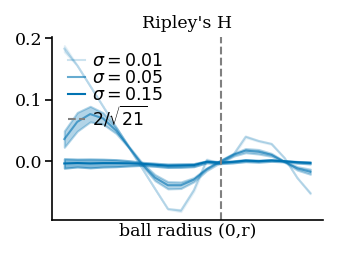

In [151]:
figsize = set_size(fraction=(0.9/2,1/3),mode='square')
fig, ax = plt.subplots(figsize=figsize)#,dpi=300)

alphas = [0.2, 0.6, 1.0]
for j in range(ripleys.shape[1]):
    ax.plot(ball_radii, np.mean(ripleys,axis=0)[j], alpha=alphas[j], color=color_cycler[0], label=r'$\sigma={}$'.format(stds[j]))
    ax.fill_between(ball_radii, np.mean(ripleys,axis=0)[j]-np.std(ripleys,axis=0)[j],
                        np.mean(ripleys,axis=0)[j]+np.std(ripleys,axis=0)[j], alpha=0.5*alphas[j], color=color_cycler[0])
ax.axvline(2/np.sqrt(21), color='grey', linestyle='--', label=r'$2/\sqrt{21}$')
ax.legend(loc='upper left')

ax.set_xlabel('ball radius ' + r'(0,r)', fontsize='small')
ax.set_title("Ripley's H", fontsize='small')
ax.set_xticks([])
fig.tight_layout(pad=0.35, w_pad=0, h_pad=0)

if savefigs:
    fig.savefig('../results/P3-ripleys-sup1')

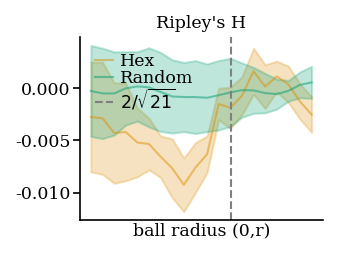

In [152]:
figsize = set_size(fraction=(0.9/2,1/3),mode='square')
fig, ax = plt.subplots(figsize=figsize)#,dpi=300)

ax.plot(ball_radii, np.mean(ripleys_random_uniform,axis=0), alpha=0.5, color=color_cycler[1], label='Hex')
ax.fill_between(ball_radii, np.mean(ripleys_random_uniform,axis=0)-np.std(ripleys_random_uniform,axis=0),
                    np.mean(ripleys_random_uniform,axis=0)+np.std(ripleys_random_uniform,axis=0), alpha=0.25, color=color_cycler[1])
ax.plot(ball_radii, np.mean(ripleys_random,axis=0), alpha=0.5, color=color_cycler[2], label='Random')
ax.fill_between(ball_radii, np.mean(ripleys_random,axis=0)-np.std(ripleys_random,axis=0),
                    np.mean(ripleys_random,axis=0)+np.std(ripleys_random,axis=0), alpha=0.25, color=color_cycler[2])
ax.axvline(2/np.sqrt(21), color='grey', linestyle='--', label=r'$2/\sqrt{21}$')
ax.legend(loc='upper left')

ax.set_xlabel('ball radius ' + r'(0,r)', fontsize='small')
ax.set_title("Ripley's H", fontsize='small')
ax.set_xticks([])
fig.tight_layout(pad=0.35, w_pad=0, h_pad=0)

if savefigs:
    fig.savefig('../results/P3-ripleys-sup2')